In [1]:
%load_ext autoreload
%autoreload 2
import splitwavepy as sw
import numpy as np
import matplotlib.pyplot as plt

In [57]:
a = sw.Data(split=(30, 1.2), noise=0.05)

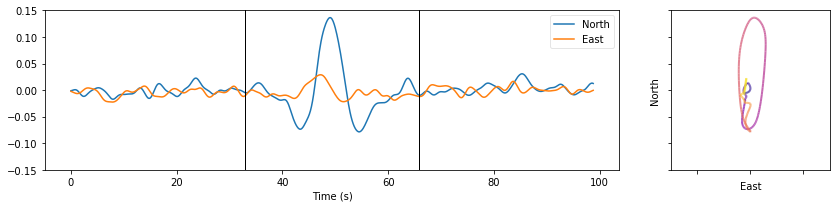

In [58]:
a.plot()

In [59]:
%timeit a.Meas().silver_chan()

100 loops, best of 3: 15.6 ms per loop


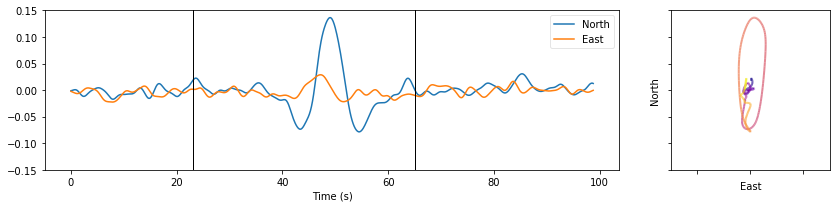

In [60]:
a.set_window(23, 65)
a.plot()

In [141]:
def set_window(data, w0, w1):
    data.set_window(w0, w1)
    return data

def scan_windows(data, w0min, w0max, w1min, w1max, nw0=10, nw1=10):
    assert w0min < w0max < w1min < w1max
    w0s = np.linspace(w0min, w0max, nw0)
    w1s = np.linspace(w1min, w1max, nw1)
    winlist = [ (w0, w1) for w0 in w0s for w1 in w1s ]
    return [ set_window(data,*win).Meas().silver_chan() for win in winlist ]
#     return [ data.set_window(w0, w1).Meas().silver_chan() for w0 in w0s for w1 in w1s ]

def cluster(data, w0min, w0max, w1min, w1max,**kwargs):
    
    scan = scan_windows()
    
    

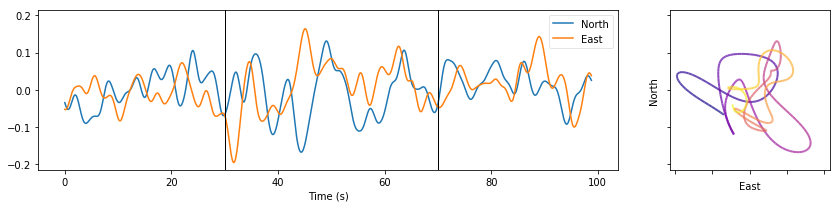

In [179]:
a = sw.Data(split=(30, 1.2), noise=0.25)
results = scan_windows(a, 20, 30, 60, 70)
a.plot()
# plt.scatter(re)

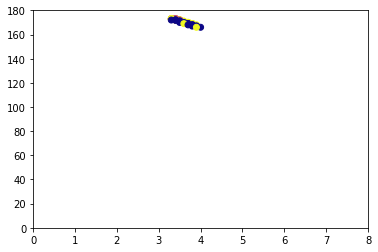

In [180]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = np.asarray(results)[:,[0,3]]
X_scaled = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.3, min_samples=10).fit(X_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# c=clusters, cmap="plasma"
plt.scatter(resarray[:,2], resarray[:,0], c=labels, cmap='plasma')
plt.xlim(0,8)
plt.ylim(0,180)
plt.show()

In [139]:
def scan_windows_surfaces(data, w0min, w0max, w1min, w1max, nw0=10, nw1=10):
    assert w0min < w0max < w1min < w1max
    w0s = np.linspace(w0min, w0max, nw0)
    w1s = np.linspace(w1min, w1max, nw1)
    winlist = [ (w0, w1) for w0 in w0s for w1 in w1s ]
    Ms = [ set_window(data,*win).Meas() for win in winlist ]
    return Ms
    
#     return [ data.set_window(w0, w1).Meas().silver_chan() for w0 in w0s for w1 in w1s ]

In [140]:
def stack(ms):
    nlags = min([ m._lags.size for m in ms ])
    return np.stack([m.bszrhopdf()[:nlags,:] + m.bslamratpdf()[:nlags,:] for m in ms])

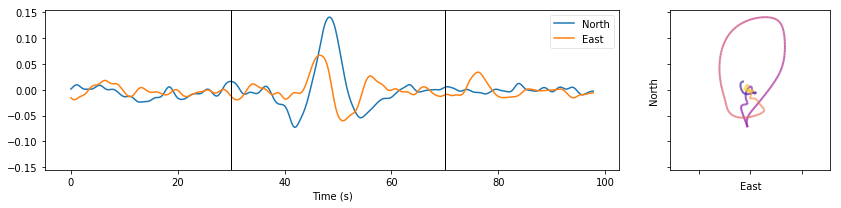

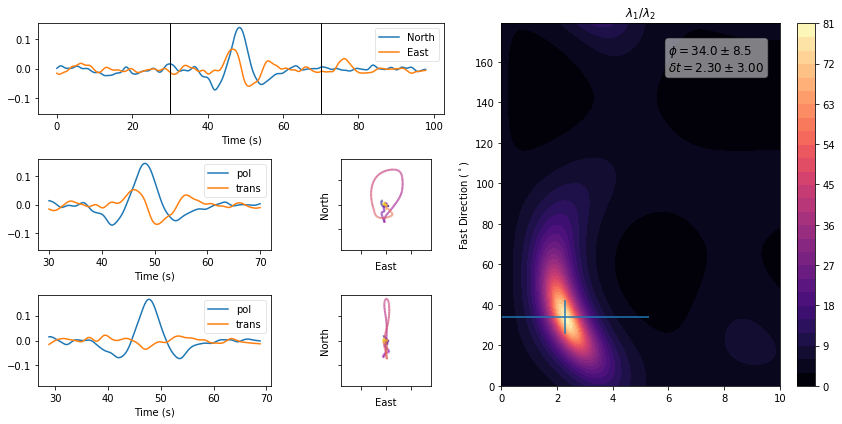

In [353]:
a = sw.Data(split=(30, 2.2), noise=0.05)
results = scan_windows(a, 20, 30, 60, 70)
a.plot()
a.Meas().plot()
ms = scan_windows_surfaces(a, 20, 30, 60, 70)

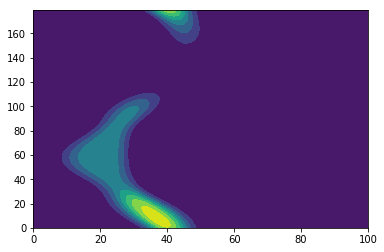

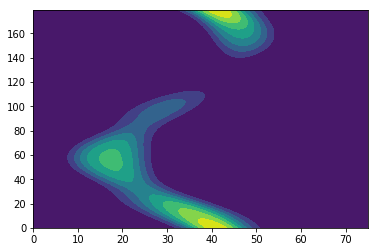

In [273]:
plt.contourf((ms[0].bszrhopdf() + ms[0].bslamratpdf()).T)
plt.show()


plt.contourf(np.sum(stack(ms), axis=0).T)
plt.show()

In [284]:
%timeit m.flam2pdf

100 loops, best of 3: 8.03 ms per loop


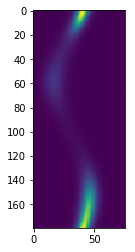

In [310]:
%matplotlib inline
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
fig = plt.figure()
ims = []
nlags = min([ m._lags.size for m in ms ])
for m in ms:
    ims.append([plt.imshow(m.f_lamrat[:nlags,:].T + m.f_rho[:nlags,:].T, animated=True)])
ani = animation.ArtistAnimation(fig, ims, interval=50, 
                                blit=True, repeat_delay=1000)
ani

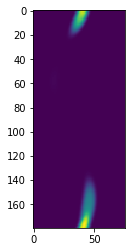

In [292]:
%matplotlib inline
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
fig = plt.figure()
ims = []
nlags = min([ m._lags.size for m in ms ])
for m in ms:
    ims.append([plt.imshow(m.bslam2pdf[:nlags,:].T + m.bszrhopdf[:nlags,:].T, animated=True)])
ani = animation.ArtistAnimation(fig, ims, interval=50, 
                                blit=True, repeat_delay=1000)
ani

In [135]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


In [172]:
X = np.asarray(results)[:,[0,3]]
X_scaled = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.3, min_samples=10).fit(X_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


In [173]:
labels.shape

(100,)

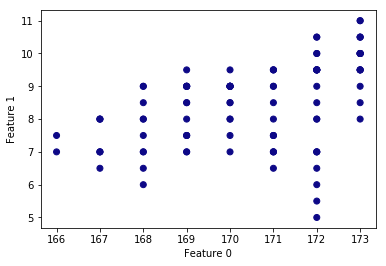

In [174]:
clusters = db.fit_predict(X_scaled)
# plot the cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

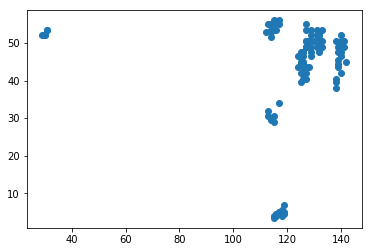

In [168]:
plt.scatter(np.asarray(results)[:,[0]], np.asarray(results)[:,[3]])
plt.show()

In [366]:
ms = scan_windows_surfaces(a, 20, 30, 60, 70)
m = ms[0]


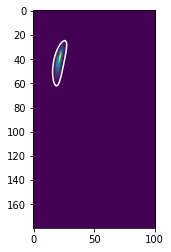

In [356]:
# plt.imshow(m.pdf.T)
c = m.contour(m.pdf, 0.05)
plt.imshow(m.pdf.T)
plt.contour(m.pdf.T, levels=[c], colors='white')

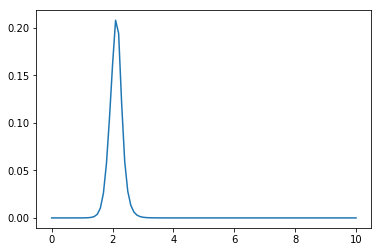

In [361]:
plt.plot(m._lags, m.lagprofile)

In [368]:
print(m.fast, m.dfast, m.lag, m.dlag)

37.0 18.5 2.2 6.0


In [376]:
m.data.pol

AttributeError: 'Data' object has no attribute 'pol'

In [324]:
sw.core.core.val_at_alpha(m.pdf, 0.05)

array(1.54267498e-05)

In [322]:
np.argsort(m.pdf)

array([[ 13, 103,  12, ...,  57, 148,  58],
       [115,   0, 114, ...,  59,  57,  58],
       [119, 176, 118, ...,  59,  57,  58],
       ...,
       [147, 148, 146, ...,  18,  16,  17],
       [147, 146, 148, ...,  15,  17,  16],
       [147, 146, 148, ...,  17,  15,  16]])